In [7]:
%%capture --no-stderr
%pip install -U langgraph==0.1.15 langsmith langchain-openai langchain-community --upgrade 

In [1]:
import getpass
import os

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
_set_env("TAVILY_API_KEY")

(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [15]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

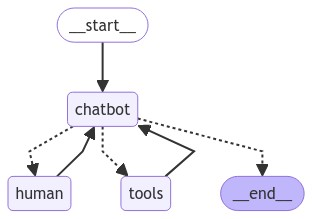

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [17]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_YHPXec2Kxyf4NUZPVj4Qns45)
 Call ID: call_YHPXec2Kxyf4NUZPVj4Qns45
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/langgraph-cloud/", "content": "LangGraph is a framework for building agentic and multi-agent applications with LLMs, and LangGraph Cloud is a scalable and reliable infrastructure for deploying them. Learn how LangGraph helps you design, debug, and monitor complex agentic workflows with LLMs."}, {"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and 

In [18]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

Building an autonomous agent with LangGraph sounds like a fascinating project! If you need any assistance or guidance along the way, feel free to reach out. Enjoy exploring and experimenting with LangGraph in your autonomous agent project!


Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [23]:
config

{'configurable': {'thread_id': '1'}}

In [25]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [26]:
print(to_replay.next)
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'thread_ts': '1ef4e858-531a-675a-8002-3cdfa16c589a'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [27]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

I found some information on LangGraph for you:

1. LangGraph is a framework for building agentic and multi-agent applications with LLMs. LangGraph Cloud is a scalable and reliable infrastructure for deploying these applications. It helps in designing, debugging, and monitoring complex agentic workflows with LLMs. You can learn more about it at [LangGraph Cloud](https://blog.langchain.dev/langgraph-cloud/).

2. LangGraph is also a library for creating stateful, multi-actor applications with LLMs. It utilizes cycles, controllability, and persistence. You can explore how to use LangGraph, examples, integration with LangChain, and streaming support on their GitHub repository: [LangGraph GitHub](https://github.com/langchain-ai/langgraph).

Feel free to explore these resources for more detailed information on LangGraph.


## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

The [LangGraph documentation](https://langchain-ai.github.io/langgraph/) is a great resource for diving deeper into the library's capabilities.